# Test methods for accessing CESM1 and CMIP6 output via Pangeo methodologies
## February 2024

In [2]:
# Packages needed generally
from matplotlib import pyplot as plt
import xarray as xr
import pandas as pd
import geopandas as gpd
import cartopy
import cartopy.crs as ccrs
import numpy as np

# Packages needed for CESM1 example
import pprint
import intake
import requests
import aiohttp
import s3fs
import xoak
import pop_tools
import xgcm

# Packages needed for CMIP6
import zarr
import gcsfs
import dask

### Example 1: CESM1 Large Ensemble

Here I will demonstrate how to extract information from the CESM1 Large Ensemble hosted on Amazon Web Services, following similar steps as 

https://github.com/dianaxnav/cesm-lens-aws-dn/tree/main

This has been modified to also include functionality to load a zarr-format grid file containing the latitude and longitude information for CESM1, which for some reason are not included in the data files. 

Things to note:
- The grid file used here is only for OCEAN variables; the atmosphere and land have different lat and lon information.
- For most ocean variables, latitude and longitude are called "TLAT" and "TLONG".

In [3]:
# Open original collection description file: CESM1 LENS
cat_url = "https://ncar-cesm-lens.s3-us-west-2.amazonaws.com/catalogs/aws-cesm1-le.json"
col = intake.open_esm_datastore(cat_url)
col

# Location of file containing grid (lat/lon) information for CESM1 LENS
grid_url="s3://ncar-cesm-lens/ocn/static/grid.zarr"

The name of the ocean temperature variable is "TEMP"; a full list of CESM-specific variable names can be found here:

https://www.cesm.ucar.edu/community-projects/lens2/output-variables

In [4]:
# Search for the TEMP variable, display the first few entries in the resulting data frame
col.search(variable="TEMP").df

,variable,long_name,component,experiment,frequency,vertical_levels,spatial_domain,units,start_time,end_time,path
0,TEMP,potential temperature,ocn,20C,monthly,60.0,global_ocean,degC,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-TEM...
1,TEMP,potential temperature,ocn,CTRL,monthly,60.0,global_ocean,degC,0400-01-16 12:00:00,2200-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-CTRL-TE...
2,TEMP,potential temperature,ocn,HIST,monthly,60.0,global_ocean,degC,1850-01-16 12:00:00,1919-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-HIST-TE...
3,TEMP,potential temperature,ocn,RCP85,monthly,60.0,global_ocean,degC,2006-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-RCP85-T...


In [5]:
# Get more detailed: search for monthly output for the 20th century and RCP8.5 
# ("HIST" is the 1850-1919 period, which is only in the first ensemble member, and "20C" is 1920-2005 which is common across all the other members = 
col_ocntemp = col.search(
    frequency=["monthly"],
    component="ocn",
    variable="TEMP",
    experiment=["20C", "RCP85"],  
)

col_ocntemp.df

,variable,long_name,component,experiment,frequency,vertical_levels,spatial_domain,units,start_time,end_time,path
0,TEMP,potential temperature,ocn,20C,monthly,60.0,global_ocean,degC,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-TEM...
1,TEMP,potential temperature,ocn,RCP85,monthly,60.0,global_ocean,degC,2006-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-RCP85-T...


In [6]:
# Load catalog entries for subset into a dictionary of xarray datasets
dsets = col_ocntemp.to_dataset_dict(
    zarr_kwargs={"consolidated": True}, storage_options={"anon": True}
)
print(f"\nDataset dictionary keys:\n {dsets.keys()}")


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency'


/Users/p_park/.conda/envs/channelislanders/lib/python3.9/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
/Users/p_park/.conda/envs/channelislanders/lib/python3.9/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)



Dataset dictionary keys:
 dict_keys(['ocn.RCP85.monthly', 'ocn.20C.monthly'])


In [7]:
# Get file containing lat/lon grid information: s3://ncar-cesm-lens/ocn/static/grid.zarr
fs = s3fs.S3FileSystem(anon=True)
grid = xr.open_zarr(fs.get_mapper(grid_url), consolidated=True)
grid

<xarray.Dataset>
Dimensions:               (nlat: 384, nlon: 320, z_t: 60, z_w: 60,
                           lat_aux_grid: 395, moc_comp: 3, moc_z: 61,
                           transport_comp: 5, transport_reg: 2, z_t_150m: 15,
                           z_w_bot: 60, z_w_top: 60)
Coordinates: (12/63)
    ANGLE                 (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    ANGLET                (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    DXT                   (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    DXU                   (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    DYT                   (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    DYU                   (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    ...                    ...
    vonkar                float64 ...
  * z_t                   (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m              (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
  * z_w                   (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot               (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * z_w_top               (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
Dimensions without coordinates: nlat, nlon, moc_comp, transport_comp,
                                transport_reg
Data variables:
    *empty*

In [8]:
# Define Xarray datasets corresponding to the two experiments
ds_20C = dsets["ocn.20C.monthly"]
ds_RCP85 = dsets["ocn.RCP85.monthly"]
ds_20C

<xarray.Dataset>
Dimensions:     (member_id: 40, time: 1032, z_t: 60, nlat: 384, nlon: 320, d2: 2)
Coordinates:
  * member_id   (member_id) int64 1 2 3 4 5 6 7 8 ... 34 35 101 102 103 104 105
  * time        (time) object 1920-01-16 12:00:00 ... 2005-12-16 12:00:00
    time_bound  (time, d2) object dask.array<chunksize=(1032, 2), meta=np.ndarray>
  * z_t         (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Dimensions without coordinates: nlat, nlon, d2
Data variables:
    TEMP        (member_id, time, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 6, 60, 384, 320), meta=np.ndarray>
Attributes: (12/24)
    Conventions:                       CF-1.0; http://www.cgd.ucar.edu/cms/ea...
    calendar:                          All years have exactly  365 days.
    cell_methods:                      cell_methods = time: mean ==> the vari...
    contents:                          Diagnostic and Prognostic Variables
    nco_openmp_thread_number:          1
    nsteps_total:                      750
    ...                                ...
    intake_esm_attrs:units:            degC
    intake_esm_attrs:start_time:       1920-01-16 12:00:00
    intake_esm_attrs:end_time:         2005-12-16 12:00:00
    intake_esm_attrs:path:             s3://ncar-cesm-lens/ocn/monthly/cesmLE...
    intake_esm_attrs:_data_format_:    zarr
    intake_esm_dataset_key:            ocn.20C.monthly

In [9]:
#average the member_id dimension
ds_20C_mean=ds_20C.mean(dim="member_id")
ds_20C_mean

<xarray.Dataset>
Dimensions:     (time: 1032, z_t: 60, nlat: 384, nlon: 320, d2: 2)
Coordinates:
  * time        (time) object 1920-01-16 12:00:00 ... 2005-12-16 12:00:00
    time_bound  (time, d2) object dask.array<chunksize=(1032, 2), meta=np.ndarray>
  * z_t         (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Dimensions without coordinates: nlat, nlon, d2
Data variables:
    TEMP        (time, z_t, nlat, nlon) float32 dask.array<chunksize=(6, 60, 384, 320), meta=np.ndarray>

In [10]:
#select a specific time slice from 1950 to 2000
#ds_20C_mean.TEMP.sel(time=slice("1950", "2000"))
ds_20C_mean.sel(time=slice("1950", "2000"))

<xarray.Dataset>
Dimensions:     (time: 612, z_t: 60, nlat: 384, nlon: 320, d2: 2)
Coordinates:
  * time        (time) object 1950-01-16 12:00:00 ... 2000-12-16 12:00:00
    time_bound  (time, d2) object dask.array<chunksize=(612, 2), meta=np.ndarray>
  * z_t         (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Dimensions without coordinates: nlat, nlon, d2
Data variables:
    TEMP        (time, z_t, nlat, nlon) float32 dask.array<chunksize=(6, 60, 384, 320), meta=np.ndarray>

<Axes: >

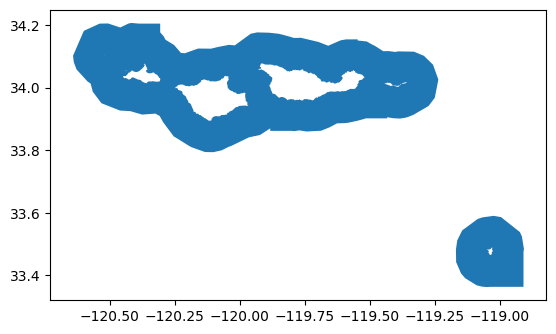

In [11]:
#how to see the channel island shapefile
# path to channel island shapefile
cinms = 'cinms_py'

# Read the shapefile
pts = gpd.read_file(cinms)

# Read the shapefile
cinms_shape = gpd.read_file(cinms).to_crs(4326)

cinms_shape.plot()

In [12]:
# # Create a plot
# fig, ax = plt.subplots(figsize=(30, 20), 
#                        subplot_kw={'projection': ccrs.PlateCarree()})

# # Plot the Xarray dataset as background
# ds_20C_mean['TEMP'].plot(ax=ax, 
#          transform=ccrs.PlateCarree())

# # Set the extent of the plot based on the shapefile bounding box
# ax.set_extent([cinm_0, cinm_2, cinm_1, cinm_3])

# # Plot the shapefile
# cinms_shape.plot(ax=ax, facecolor = "none")

# # Add gridlines
# ax.gridlines(draw_labels=True)

# # Add a title
# ax.set_title('Channel Islands Marine Sanctuary Sea Surface Temperature')

# # Show the plot
# plt.show()


In [16]:
TLONG = grid.TLONG
TLAT = grid.TLAT
TLONG

<xarray.DataArray 'TLONG' (nlat: 384, nlon: 320)>
dask.array<open_dataset-TLONG, shape=(384, 320), dtype=float64, chunksize=(192, 160), chunktype=numpy.ndarray>
Coordinates: (12/51)
    ANGLE               (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    ANGLET              (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    DXT                 (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    DXU                 (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    DYT                 (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    DYU                 (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    ...                  ...
    salt_to_ppt         float64 ...
    sea_ice_salinity    float64 ...
    sflux_factor        float64 ...
    sound               float64 ...
    stefan_boltzmann    float64 ...
    vonkar              float64 ...
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:  array of t-grid longitudes
    units:      degrees_east

In [13]:

# Merge the datasets of grid and the ds_20C data arrays
merged_dataset = xr.merge([grid, ds_20C], join = "outer")
ds_20C_merged_mean=merged_dataset.mean(dim="member_id")
ds_20C_merged_mean
#when TEMP is added in code
#test = ds_20C_merged_mean.TEMP.sel(time=slice("1950", "2000"))
#when TEMP is not added in code
test = ds_20C_merged_mean.sel(time=slice("1950", "2000"))
test
#test_2 = test
#test_2

<xarray.Dataset>
Dimensions:               (nlat: 384, nlon: 320, z_t: 60, z_w: 60,
                           lat_aux_grid: 395, moc_comp: 3, moc_z: 61,
                           transport_comp: 5, transport_reg: 2, z_t_150m: 15,
                           z_w_bot: 60, z_w_top: 60, time: 612, d2: 2)
Coordinates: (12/65)
    ANGLE                 (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    ANGLET                (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    DXT                   (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    DXU                   (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    DYT                   (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    DYU                   (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    ...                    ...
  * z_t_150m              (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
  * z_w                   (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot               (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * z_w_top               (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * time                  (time) object 1950-01-16 12:00:00 ... 2000-12-16 12...
    time_bound            (time, d2) object dask.array<chunksize=(612, 2), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon, moc_comp, transport_comp,
                                transport_reg, d2
Data variables:
    TEMP                  (time, z_t, nlat, nlon) float32 dask.array<chunksize=(6, 60, 384, 320), meta=np.ndarray>

In [15]:
TLONG = test.TLONG
TLAT = test.TLAT
TLONG

<xarray.DataArray 'TLONG' (nlat: 384, nlon: 320)>
dask.array<open_dataset-TLONG, shape=(384, 320), dtype=float64, chunksize=(192, 160), chunktype=numpy.ndarray>
Coordinates: (12/51)
    ANGLE               (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    ANGLET              (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    DXT                 (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    DXU                 (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    DYT                 (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    DYU                 (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    ...                  ...
    salt_to_ppt         float64 ...
    sea_ice_salinity    float64 ...
    sflux_factor        float64 ...
    sound               float64 ...
    stefan_boltzmann    float64 ...
    vonkar              float64 ...
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:  array of t-grid longitudes
    units:      degrees_east

In [23]:
#test_2.coords['TLONG'] = ('time', TLONG)
#test_2.coords['TLAT'] = ('time', TLAT)
test_2 = test_2.set_coords(['TLONG', 'TLAT'])
test_2



<xarray.Dataset>
Dimensions:               (nlat: 384, nlon: 320, z_t: 60, z_w: 60,
                           lat_aux_grid: 395, moc_comp: 3, moc_z: 61,
                           transport_comp: 5, transport_reg: 2, z_t_150m: 15,
                           z_w_bot: 60, z_w_top: 60, time: 612, d2: 2)
Coordinates: (12/65)
    ANGLE                 (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    ANGLET                (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    DXT                   (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    DXU                   (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    DYT                   (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    DYU                   (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    ...                    ...
  * z_t_150m              (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
  * z_w                   (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot               (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * z_w_top               (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * time                  (time) object 1950-01-16 12:00:00 ... 2000-12-16 12...
    time_bound            (time, d2) object dask.array<chunksize=(612, 2), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon, moc_comp, transport_comp,
                                transport_reg, d2
Data variables:
    TEMP                  (time, z_t, nlat, nlon) float32 dask.array<chunksize=(6, 60, 384, 320), meta=np.ndarray>

In [18]:
# subset the region to the channel island region
#subset the region box
regbox=[10, 50, 150, 300]
# Read in specified region
mask_lon = (test.TLONG >= regbox[2]) & (test.TLONG <= regbox[3])
mask_lat = (test.TLAT >= regbox[0]) & (test.TLAT <= regbox[1])
temp=test.where(mask_lon.compute() & mask_lat.compute(), drop=True)
temp

#grid spacing in CESM is about 1 degree

#mean the z_t dimension
test_2000_2 = temp.TEMP.mean(dim = "z_t")
test_2000_2

#mean the time dimension (cannot mean the time dimension if you want to get the map)
mean_temp = test_2000_2.mean("time")
mean_temp


<xarray.DataArray 'TEMP' (nlat: 102, nlon: 133)>
dask.array<mean_agg-aggregate, shape=(102, 133), dtype=float32, chunksize=(102, 133), chunktype=numpy.ndarray>
Coordinates: (12/51)
    ANGLE               (nlat, nlon) float64 -0.0007093 -0.0007791 ... -0.07511
    ANGLET              (nlat, nlon) float64 -0.0006559 -0.000724 ... -0.07601
    DXT                 (nlat, nlon) float64 1.231e+07 1.231e+07 ... 7.614e+06
    DXU                 (nlat, nlon) float64 1.231e+07 1.231e+07 ... 7.576e+06
    DYT                 (nlat, nlon) float64 3.111e+06 3.111e+06 ... 4.48e+06
    DYU                 (nlat, nlon) float64 3.119e+06 3.118e+06 ... 4.469e+06
    ...                  ...
    salt_to_ppt         float64 1e+03
    sea_ice_salinity    float64 4.0
    sflux_factor        float64 0.1
    sound               float64 1.5e+05
    stefan_boltzmann    float64 5.67e-08
    vonkar              float64 0.4
Dimensions without coordinates: nlat, nlon

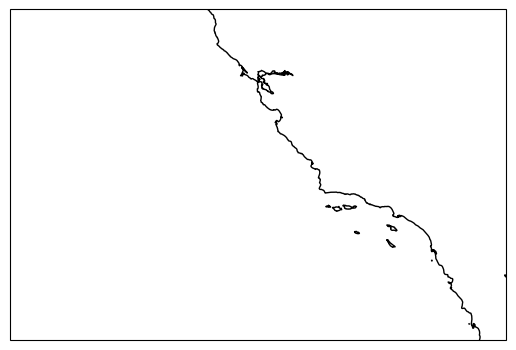

In [14]:
plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-115,-130,30,40])
ax.coastlines()

In [ ]:
fig = plt.figure(figsize=(15, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-115,-130,30,40])   # change region of interest if desired
ax.coastlines()  # add coastlines

# Add coloring for ocean
ax.add_feature(cartopy.feature.OCEAN)
# Add state boundaries
ax.add_feature(cartopy.feature.STATES)

# Add precipitation data
cf = ax.contourf(temp.TLONG, temp.TLAT, mean_temp, transform=ccrs.PlateCarree(), cmap='Greens', extend="both", vmax=10)

# Add colorbar
fig.colorbar(cf,ax=ax)

In [50]:
test_2000_2 = temp.TEMP.sel(z_t = 0, method = "nearest")
#test_2000_2
point = test_2000_2.sel(time='2000')
point

<xarray.DataArray 'TEMP' (time: 12, nlat: 102, nlon: 133)>
dask.array<getitem, shape=(12, 102, 133), dtype=float32, chunksize=(6, 102, 133), chunktype=numpy.ndarray>
Coordinates: (12/54)
    ANGLE               (nlat, nlon) float64 -0.0007093 -0.0007791 ... -0.07511
    ANGLET              (nlat, nlon) float64 -0.0006559 -0.000724 ... -0.07601
    DXT                 (nlat, nlon) float64 1.231e+07 1.231e+07 ... 7.614e+06
    DXU                 (nlat, nlon) float64 1.231e+07 1.231e+07 ... 7.576e+06
    DYT                 (nlat, nlon) float64 3.111e+06 3.111e+06 ... 4.48e+06
    DYU                 (nlat, nlon) float64 3.119e+06 3.118e+06 ... 4.469e+06
    ...                  ...
    sflux_factor        float64 0.1
    sound               float64 1.5e+05
    stefan_boltzmann    float64 5.67e-08
    vonkar              float64 0.4
    z_t                 float32 500.0
  * time                (time) object 2000-01-16 12:00:00 ... 2000-12-16 12:0...
Dimensions without coordinates: nlat, nlon

(array([  524.,  1112.,  2904.,  5105.,  6648.,  8679., 10702., 15886.,
        39361., 21771.]),
 array([-1.7663548 ,  1.45308554,  4.67252588,  7.89196634, 11.11140633,
        14.33084679, 17.55028725, 20.76972771, 23.98916817, 27.20860863,
        30.42804909]),
 <BarContainer object of 10 artists>)

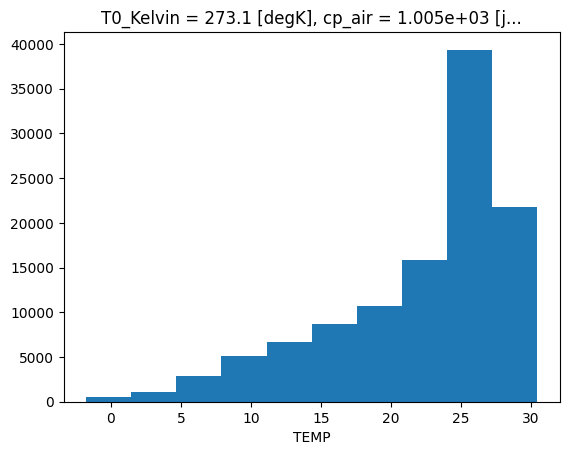

In [25]:
#trying to time series line graph
#test_2000 = temp.sel(time='2000-03')
#test_2000.TEMP.plot.line(x = 'time')


test_2000_2 = temp.TEMP.sel(z_t = 500)
test_2000_2
point = test_2000_2.sel(time='2000')
point.plot()

#question: why is it showing up as an histogram? what is on the y axis?



In [19]:
test_2000 = temp.TEMP.sel(time='2000-03')
test_2000_2 = test_2000.mean(dim = "z_t")
test_2000_2

<xarray.DataArray 'TEMP' (time: 1, nlat: 102, nlon: 133)>
dask.array<mean_agg-aggregate, shape=(1, 102, 133), dtype=float32, chunksize=(1, 102, 133), chunktype=numpy.ndarray>
Coordinates: (12/52)
    ANGLE               (nlat, nlon) float64 -0.0007093 -0.0007791 ... -0.07511
    ANGLET              (nlat, nlon) float64 -0.0006559 -0.000724 ... -0.07601
    DXT                 (nlat, nlon) float64 1.231e+07 1.231e+07 ... 7.614e+06
    DXU                 (nlat, nlon) float64 1.231e+07 1.231e+07 ... 7.576e+06
    DYT                 (nlat, nlon) float64 3.111e+06 3.111e+06 ... 4.48e+06
    DYU                 (nlat, nlon) float64 3.119e+06 3.118e+06 ... 4.469e+06
    ...                  ...
    sea_ice_salinity    float64 4.0
    sflux_factor        float64 0.1
    sound               float64 1.5e+05
    stefan_boltzmann    float64 5.67e-08
    vonkar              float64 0.4
  * time                (time) object 2000-03-16 12:00:00
Dimensions without coordinates: nlat, nlon

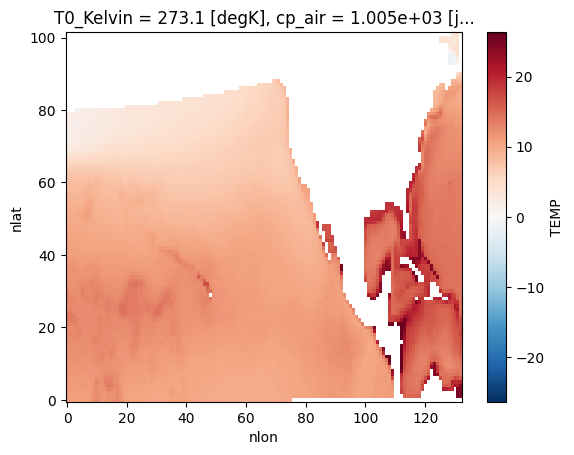

In [27]:
# how to get map
test_2000 = temp.TEMP.sel(time='2000-03')
test_2000_2 = test_2000.mean(dim = "z_t")
test_2000_2.plot()

Where I am getting the info to transform the data:
https://stackoverflow.com/questions/58758480/xarray-select-nearest-lat-lon-with-multi-dimension-coordinates?rq=1
maybe not useful but can go back to it cause it could help

In [ ]:
#find additional information on the coordinates
print(temp.TLONG.attrs)
print(temp.TLAT.attrs)

In [ ]:
#just plot these coordinates to have an idea of what they look like
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 4))
temp.TLONG.plot(ax=ax1)
temp.TLAT.plot(ax=ax2)

#or
#temp.nlat or temp.nlon for the plot part

In [ ]:
#just plot these coordinates to have an idea of what they look like
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 4))
temp.nlon.plot(ax=ax1)
temp.nlat.plot(ax=ax2)

In [ ]:
grid, xds = pop_tools.to_xgcm_grid_dataset(temp)

In [ ]:
xds

In [ ]:
grid

In [ ]:
xds.xoak.set_index(['TLAT', 'TLONG'], 'scipy_kdtree')
xds

In [25]:
# Define the coordinates of the sanctuary boundaries
sanctuary_boundaries = {
    'TLAT': slice(-120.64208, -118.90879),  # Longitude range
    'TLONG': slice(33.36241, 34.20492)       # Latitude range
}

# Subset the merged dataset to include data within the sanctuary boundaries
ds_20C_sanctuary = temp.sel(**sanctuary_boundaries)


# Now you can continue analyzing or plotting the data within the sanctuary boundaries
ds_20C_sanctuary

KeyError: "no index found for coordinate 'TLAT'"

In [ ]:
#probably correct way to do it?
# Define the coordinates of the sanctuary boundaries
sanctuary_boundaries = {
    'nlat': slice(200,300),  # Longitude range
    'nlon': slice(200,260)       # Latitude range
}

# Subset the merged dataset to include data within the sanctuary boundaries
ds_20C_sanctuary = ds_20C_merged_mean.sel(**sanctuary_boundaries)



# Now you can continue analyzing or plotting the data within the sanctuary boundaries
ds_20C_sanctuary

In [ ]:
ds_20C_sanctuary_mean = ds_20C_sanctuary.TEMP.sel(time=slice("1950", "2000"))
ds_20C_sanctuary_mean

test_2000 = ds_20C_sanctuary_mean.sel(time='2000-03')
test_2000
#test_2000.squeeze().plot()


NOTE: 
if the variable in interest is taken out, then it plots a bar graph (which i think is the 'vertical profile')

### Example 2: CMIP6

Now I'll do the same thing for the multi-model CMIP6 database, following procedures similar to

https://github.com/pangeo-data/pangeo-cmip6-examples/blob/master/basic_search_and_load.ipynb

In [ ]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()

In [ ]:
# Locate monthly sea surface temperature (tos) from all simulations of the historical period
df_ta = df.query("activity_id=='CMIP' & table_id == 'Omon' & variable_id == 'tos' & experiment_id == 'historical'")
df_ta

In [ ]:
# Get only information for a specific model: say, CanESM5
df_ta_canesm5 = df_ta.query('source_id == "CanESM5"')
df_ta_canesm5

In [ ]:
# create login credentials, for accessing file system anonymously: this only needs to be created once
gcs = gcsfs.GCSFileSystem(token='anon')

In [ ]:
# get all paths to the relevant datasets
zstore = df_ta_canesm5.zstore

# display them
zstore

In [ ]:
# Test data I/O by using the first entry in the data table
zstore = df_ta_canesm5.zstore.values[-1]

# create a mutable-mapping-style interface to the store
mapper = gcs.get_mapper(zstore)

# open it using xarray and zarr
ds = xr.open_zarr(mapper, consolidated=True)
ds

In [ ]:
ds.tos.sel(time='2010-03').squeeze().plot()

In [ ]:
# # Create a plot
# fig, ax = plt.subplots(figsize=(30, 20), 
#                        subplot_kw={'projection': ccrs.PlateCarree()})

# # Plot the Xarray dataset as background
# ds_20C_mean['TEMP'].plot(ax=ax, 
#          transform=ccrs.PlateCarree())

# # Set the extent of the plot based on the shapefile bounding box
# ax.set_extent([cinm_0, cinm_2, cinm_1, cinm_3])

# # Plot the shapefile
# #cinms_shape.plot(ax=ax, facecolor = "none")

# # Add gridlines
# ax.gridlines(draw_labels=True)

# # Add a title
# ax.set_title('Channel Islands Marine Sanctuary Sea Surface Temperature')

# # Show the plot
# plt.show()

In [ ]:
# Merge the datasets
#merged_dataset = xr.merge([grid] + list(dsets.values()))

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Assuming ds.tos has dimensions (time, lat, lon)
tos_at_specific_time = ds.tos.sel(time='2010-03').mean(dim="time")

# Set up the plot
fig = plt.figure(figsize=[10, 5])
ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines()
# Plot the data
tos_at_specific_time.plot.pcolormesh(ax=ax, cmap='coolwarm', x='longitude', y='latitude')
plt.title('Mean Sea Surface Temperature (March 2010)')
plt.xlabel('Longitude') 
plt.ylabel('Latitude')

plt.show()
